# Simulating Heisenberg Spin Chains in Python using Qiskit

Heisenberg spin chains are 1D spin lattices with coupling interaction, J. They are the simplest formulation of the quantum Heisenberg model. The quantum Heisenberg model is similar to the classical Ising model, however, the Heisenberg model exploits Pauli spin-1/2 operators acting on acomposite space $(\mathbb{C}^{2})^{\otimes 𝑁}$. The XXZ spin chain is defined with the following Hamiltonian:

\begin{equation*}
H = -J\sum_{j=1}^{N-1} \left( \sigma_j^x \sigma_{j+1}^x + \sigma_j^y \sigma_{j+1}^y \right) + U\sum_{j=1}^{N-1} \sigma_j^z \sigma_{j+1}^z
\end{equation*}

Where $\sigma_{j}^{\alpha}$ are the Pauli operators acting on the jth qubit as follows:
\begin{equation*}
I^{\otimes j} \otimes \sigma^{\alpha} \otimes I^{\otimes (N-j)}
\end{equation*}

In this notebook we will calculate the Von Neumann entropy, $S_{VN}$. The Von Neumann entropy is a bipartite entanglement of a state. For a system composed of sub-systems, $A$ and $B$, the Von Neumann entropy of a subsystem, $A$ as:
\begin{equation*}
S_{A} = -tr(\rho_{A} \ln(\rho_{A}))
\end{equation*}
For a pure state, $S_{A} = S_{B}$ and $\rho_{A} = -tr_{B}(|\Psi \rangle \langle \Psi |)$. We define $S_{A}$ as a function of the state, $|\Psi \rangle$. We will define $S_{A}$ as follows:

In [2]:
import numpy as np
from qiskit.quantum_info import entropy,  partial_trace

def S_A(state, subsystem):
    """
    Calculates the Von-Neumann entropy of a sub-system.
    Args:
        state (Statevector)
        subsystemA (array)
    Returns
        float
    """
    rho_A = partial_trace(state, subsystem)
    
    return entropy(rho_A, base=np.e)

We will define a simple function that defines the Neel state as a statevector for some arbitrary $N$ qubits: $|\Psi_0\rangle = |↑↓↑↓ \cdots ↑↓↑ \rangle$


In [3]:
from qiskit.quantum_info import Statevector

def Neel(N):
    """
    Defines the statevector for the Neél state of n qubits.
    Args:
        n (int): number of qubits
    Returns:
        Statevector
    """
    return Statevector.from_label(''.join(['1' if i % 2 != 0 else '0' for i in range(N)]))

#This can also be done by applying an X gate to every second qubit

For ease of access, we will also define a simulation function that takes a circuit as input and returns the statevector

In [4]:
from qiskit import Aer, execute

def simulate(qc):
    """
    Simulates a quantum circuit on a backend and returns statevector
    Args:
        qc (QuantumCircuit)
    Returns:
        Statevector
    """
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    statevector = result.get_statevector()

    return statevector 

To perform time evolution on our initial state, we must determine the time evolution operator, 𝑈̂(𝑡) in terms of quantum gates. The time evolution operator can be discretised into ‘Trotter steps’,
$U(t) \approx \ U(\Delta t) \cdots U(\Delta t)$. We will use an easily understandable approach using the Trotterisation:
\begin{equation*}
U(\Delta t) \approx \exp(-i(\hat{H}_{XX} + \hat{H}_{YY})\Delta t) \approx \exp(-i\hat{H}_{XX} \Delta t)  \exp(-i \hat{H}_{YY} \Delta t) + O(\Delta t^2)
\end{equation*}

Where 
\begin{equation*}
\hat{H}_{XX} = -J \sum_{j=1}^{N-1} \sigma_{j}^{x} \sigma_{j+1}^{x} \ \ \ \text{and} \ \ \ \hat{H}_{YY} = -J \sum_{j=1}^{N-1} \sigma_{j}^{y} \sigma_{j+1}^{y}
\end{equation*}

Therefore, our disrete time evolution operator is as follows:
\begin{equation*}
\hat{U} (\Delta t) \approx \prod_{j=1}^{N-1} \exp( -iJ \Delta t \sigma_{j}^{x} \sigma_{j+1}^{x})  \exp( -iJ \Delta t \sigma_{j}^{y} \sigma_{j+1}^{y})
\end{equation*}

To obtain $U(\Delta t)$ in terms of quantum gates, we can use the following identity for some operator $\hat{O}$
\begin{equation*}
\exp(i \theta \hat{O}) = cos(\theta) \hat{I} + i sin(\theta) \hat{O}
\end{equation*}

Firstly, we can obtain:
\begin{equation*}
\exp(-iJ \Delta t \sigma_{j}^{x} \sigma_{j+1}^{x}) = cos(J \Delta t) - i sin(J \Delta t) 
\end{equation*}

Consider any pair of qubits:
\begin{equation*}
\sigma_{j}^{x} \sigma_{j+1}^{x} = (X \otimes I)(I \otimes X) = 
\begin{bmatrix}
    0 & 0 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 1 & 0 & 0 \\
    1 & 0 & 0 & 0 \\
\end{bmatrix}
\end{equation*}

We can express $\exp(-iJ \Delta t \sigma_{j}^{x} \sigma_{j+1}^{x})$ in matrix form. This is the $R_{XX}$ gate:
\begin{equation*}
\ R_{XX}(2\theta) = \begin{bmatrix}
    cos(\theta) & 0 & 0 & -i \sin(\theta) \\
    0 & \cos(\theta) & -i \sin(\theta) & 0 \\
    0 & -i \sin(\theta) & \cos(\theta) & 0 \\
    -i \sin(\theta) & 0 & 0 & \cos(\theta) \\
\end{bmatrix}
\end{equation*}

where $\theta = J \Delta t$. Similarly, the evolution of the YY interaction gate can written as:

\begin{equation*}
\ R_{YY}(2\theta) = \begin{bmatrix}
    cos(\theta) & 0 & 0 & i sin(\theta) \\
    0 & cos(\theta) & -i sin(\theta) & 0 \\
    0 & -i sin(\theta) & cos(\theta) & 0 \\
    i sin(\theta) & 0 & 0 & cos(\theta) \\
\end{bmatrix}
\end{equation*}

So all together our discrete time evolution operator is:
\begin{equation*}
\hat{U}(\Delta t) \approx \prod_{j}^{N-1} R_{X_{j}X_{j+1}}(2 \theta) R_{Y_{j}Y_{j+1}}(2 \theta)
\end{equation*}

Conveniently, Qiskit has both the $R_{XX}$ and $R_{YY}$ operators which can be automatically decomposed into rotation gates, CNOTs and Hadamards.

Our decomposed discrete time evolution operator:


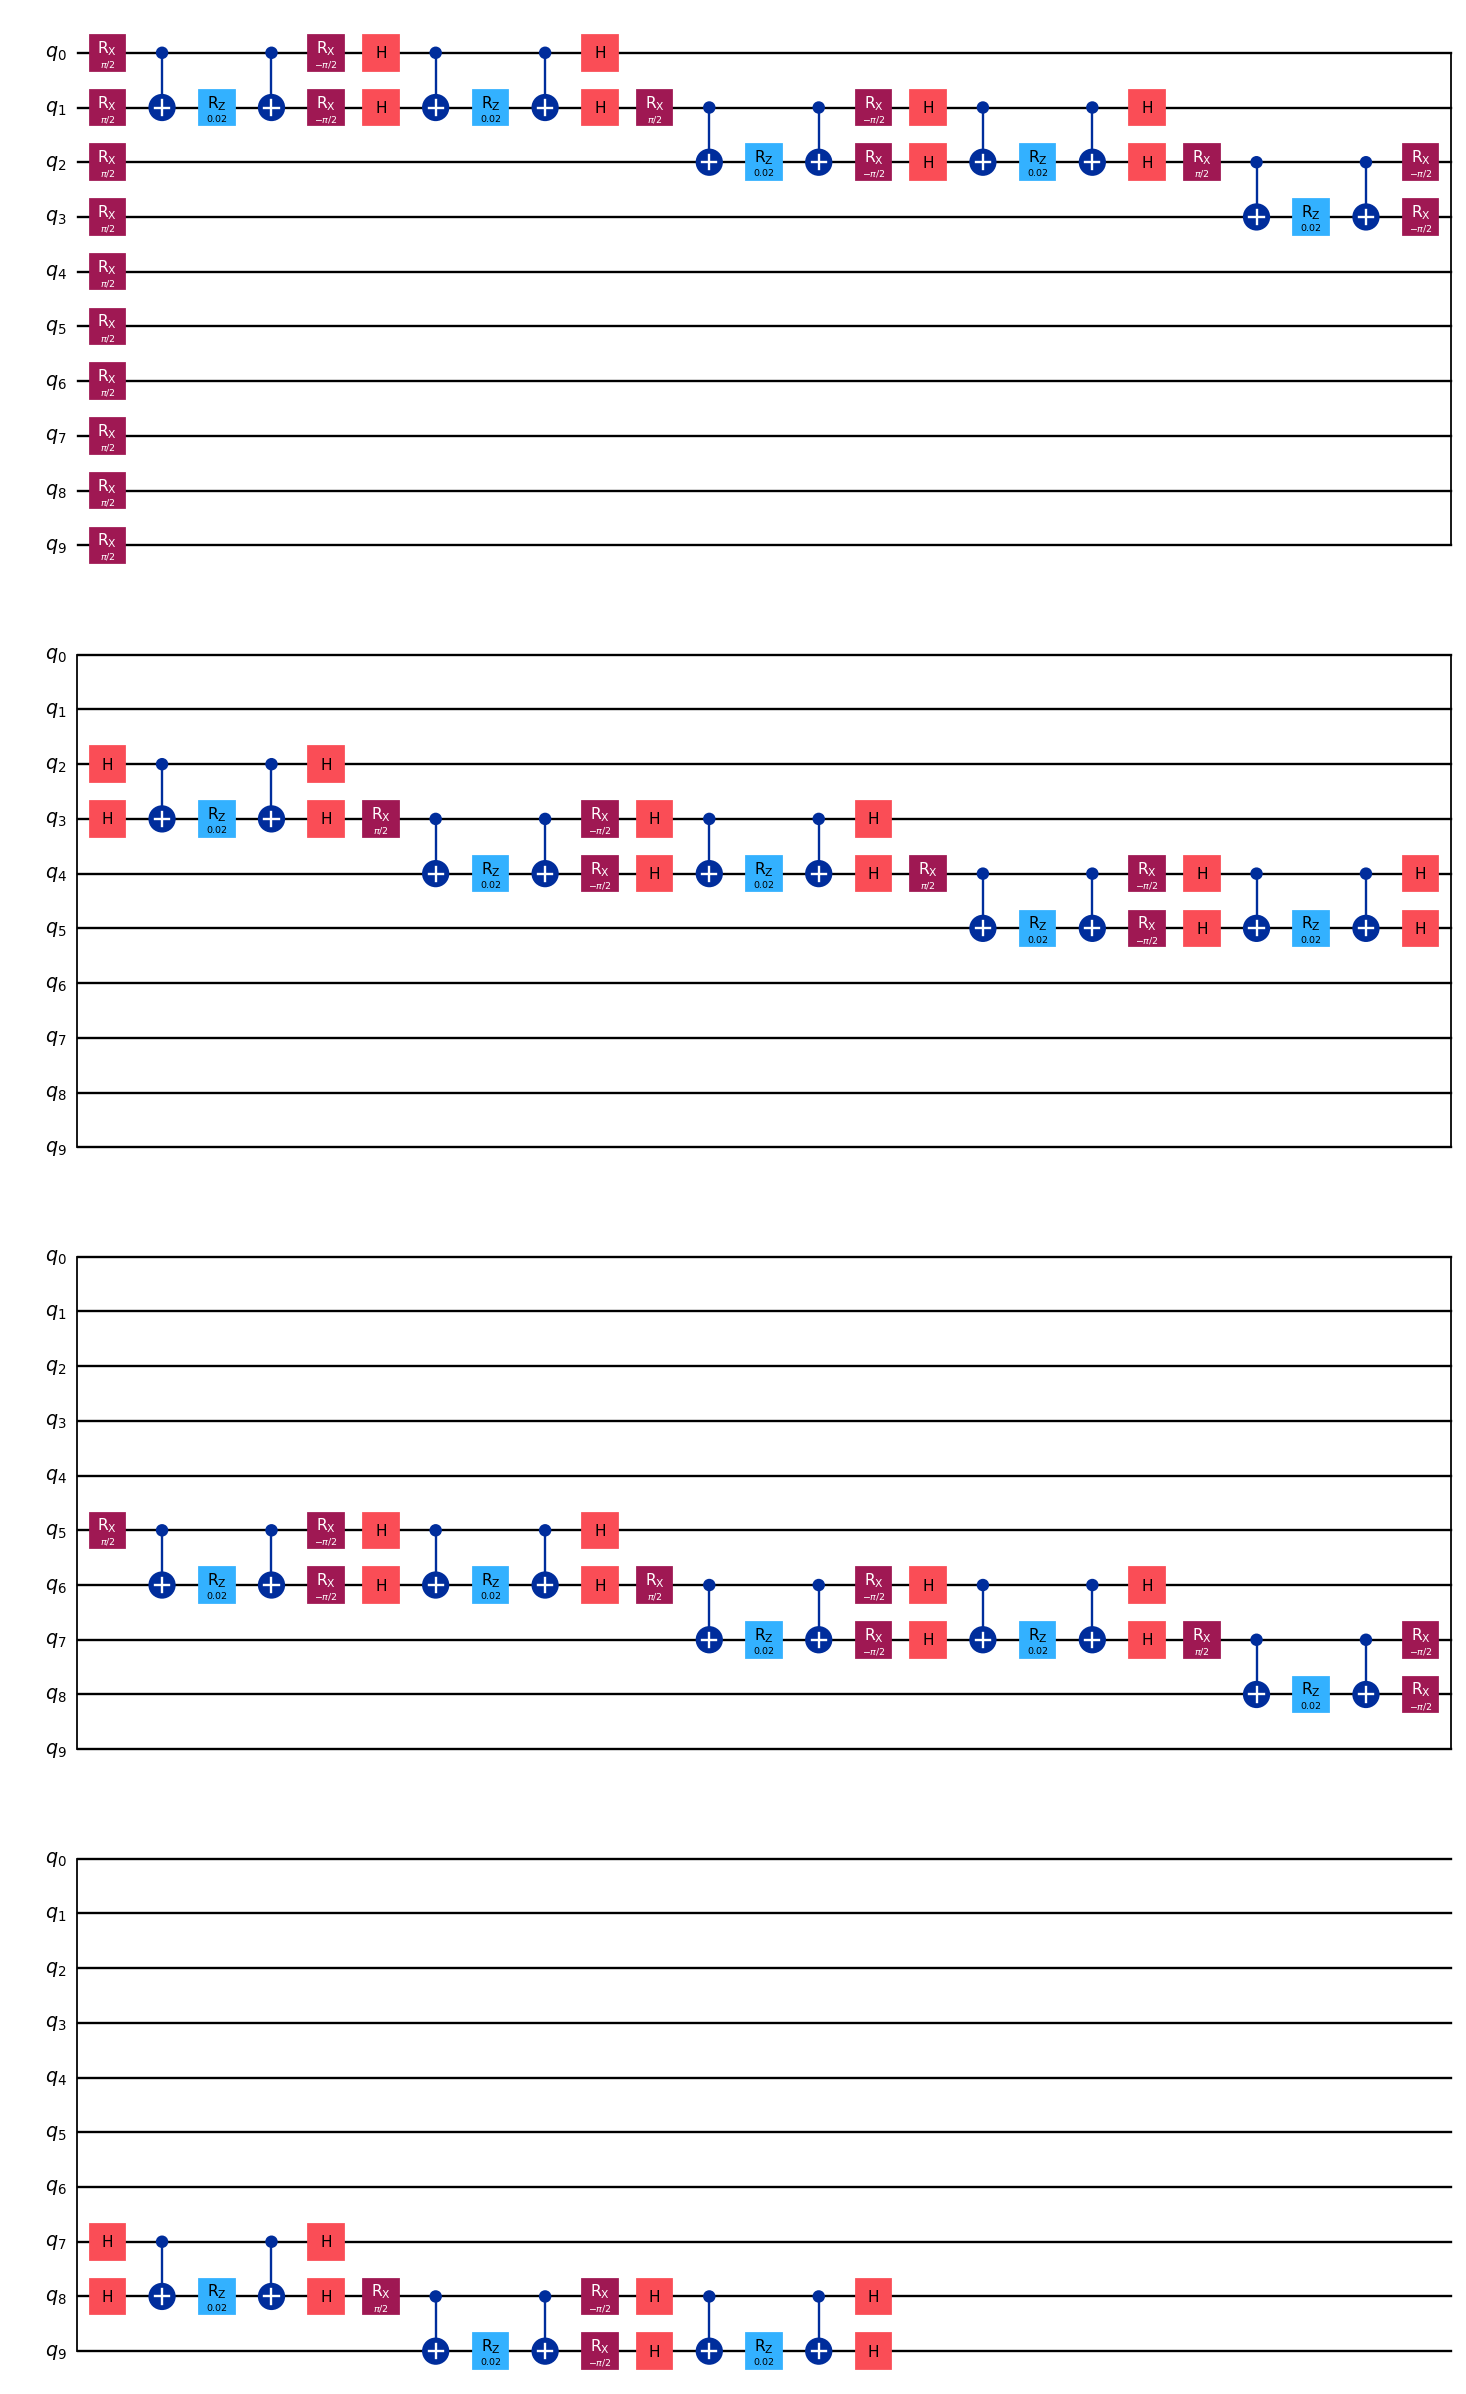

In [5]:
from qiskit import QuantumCircuit


def U_dt(state, dt):
    """
    Performs discrete time evolution on a state
    """
    N = 10
    J = 1
    qc = QuantumCircuit(N)

    if isinstance(state, Statevector) and len(state.data) != 0:
        qc.initialize(state)

    for i in range(1, N):
        qc.ryy(J * dt * 2, i - 1, i)        
        qc.rxx(J * dt * 2, i - 1, i)

    return qc 

print("Our decomposed discrete time evolution operator:")
U_dt([], 0.01).decompose().draw(output='mpl', style='iqp', scale=0.85)

Now repeatedly perform time evolution on the initial state and measure the Von Neumann entropy over time.

In [7]:
# Initialise constants:
N = 10
T = 3
dt = 0.01
J = 1
nt = int(T/dt)
state = Neel(N)
entropy_t = [] # Array to contain the entanglement entropy wrt time

# For each time-step calculate the entropy and evolve the state
for i in range(nt):
    entropy_t.append(S_A(state, range(int(N/2))))
    state = simulate(U_dt(state, dt))

C:\Users\awals\AppData\Local\Temp\ipykernel_34784\3112785285.py:12: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc, backend)


Plot the entanglement entropy generated by Qiskit & QuTiP and compare the results.

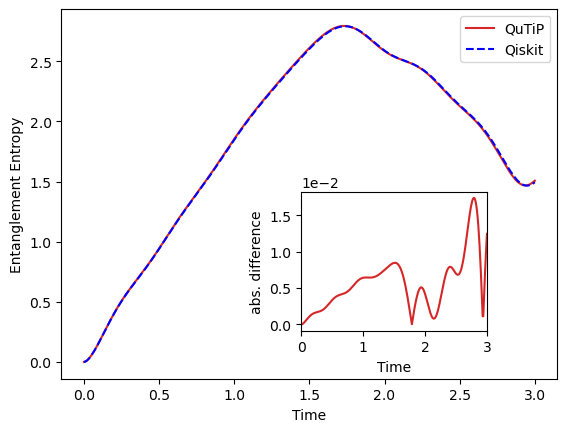

In [58]:
import matplotlib.pylab as plt

# For the sake of comparison, let's compare the entanglement entropy data generated for an identical spin chain in QuTiP.
#import the entanglement entropy data from qutip.ipynb
%store -r S_qutip

# Calculate difference between Qiskit & Qutip
diff = [abs(S_qutip[i] - entropy_t[i]) for i in range(len(entropy_t))]

fig, ax_main = plt.subplots()
left, bottom, width, height = 0.5, 0.21, 0.29, 0.29
ax_main.plot(np.linspace(0, T, nt),S_qutip, color='tab:red', label='QuTiP', linestyle='-')
ax_main.plot(np.linspace(0, T, nt),entropy_t, color='blue', label='Qiskit', linestyle='--')
ax_main.set_ylabel('Entanglement Entropy')
ax_main.set_xlabel('Time')
ax_main.legend()

ax_small = fig.add_axes([left, bottom, width, height])
ax_small.plot(np.linspace(0, T, nt), diff, color='tab:red')
ax_small.set_xlabel('Time')
ax_small.set_ylabel('abs. difference')
ax_small.set_xlim(0, 3)
ax_small.ticklabel_format(axis='y', style='sci', scilimits=(-2, 0))


These results are nearly identical. 